"""
Process Pavitra Emissions
@author: lucarojasmendoza
last modified: 2024-01-29
"""

In [99]:
#import packages
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import box
from shapely.geometry import Point
from datetime import datetime
import os
from time import time
from cmcrameri import cm
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import xarray as xr

#This is code that needs to be improved and cannot be assumed to be accurate. There may be errors in the code
#Please do not use this code to process emissions files without having a clear understanding of what each line of 
#code is exactly doing.
%run process_pavitra_emissions.py

In [3]:
source_crs = "+proj=merc +units=m +a=6370000.0 +b=6370000.0 +lon_0=80.0 +lat_ts=15.0 +no_defs"

# Convert Emissions to Shapefile (Except VOCs)

In [14]:
# Define a list of pollutants
#original file name was SO2
pollutants = ['NH3', 'BC', 'MM', 'NOx', 'OC', 'SOx']

# Loop through each pollutant
for pollutant in pollutants:
    netcdf_file_path = f'/Volumes/lrojasm/2019_emissions_ground_elevated/{pollutant}_anthro_201901-201912_merged_average.nc'
    variable_names = ['ground', 'ene']
    output_path = f'Processed_Emissions_2019_Pavitra/{pollutant}_2019_ground_elevated.shp'
    
    # Check if the netCDF file exists
    if os.path.exists(netcdf_file_path):
        # Process and save the data
        process_netCDF_and_save(netcdf_file_path, variable_names, pollutant, output_path)
    else:
        print(f"File not found: {netcdf_file_path}")

# Process VOC Emissions

In [15]:
# Define a list of pollutants
pollutants = ['OL2', 'OLI', 'OLT', 'ORA1', 'ORA2', 'TOL','XYL','ETH','HC3','HC5','HC8','HCHO','ISO','KET','ALD']

# Loop through each pollutant
#Files were created using bash.
for pollutant in pollutants:
    netcdf_file_path = f'/Volumes/lrojasm/2019_emissions_ground_elevated/{pollutant}_anthro_COALESCE_201501-201512_average.nc'    
    variable_names = ['ground', 'ene']
    output_path = f'Processed_Emissions_2019_Pavitra/{pollutant}_2015_VOC_ground_elevated.shp'
    
    # Check if the netCDF file exists
    if os.path.exists(netcdf_file_path):
        # Process and save the data
        process_netCDF_and_save(netcdf_file_path, variable_names, pollutant, output_path)
    else:
        print(f"File not found: {netcdf_file_path}")

In [16]:
# List of pollutants
pollutants = ['OL2', 'OLI', 'OLT', 'ORA1', 'ORA2', 'TOL', 'XYL', 'ETH', 'HC3', 'HC5', 'HC8', 'HCHO', 'ISO', 'KET', 'ALD']

# Initialize the combined GeoDataFrame using the first pollutant
first_pollutant = pollutants[0]
combined_gdf = gpd.read_file(f'Processed_Emissions_2019_Pavitra/{first_pollutant}_2015_VOC_ground_elevated.shp')

# List to store 'pollutant' arrays
pollutant_arrays = [combined_gdf[pollutants[0]].values]

# Loop through the remaining pollutants and load their 'pollutant' arrays
for pollutant in pollutants[1:]:
    file_path = f'Processed_Emissions_2019_Pavitra/{pollutant}_2015_VOC_ground_elevated.shp'
    if os.path.exists(file_path):
        gdf = gpd.read_file(file_path)
        pollutant_arrays.append(gdf[pollutant].values)

# Add a 'VOC' column by summing up the pollutant arrays
# verify axis 
combined_gdf['VOC'] = np.sum(pollutant_arrays, axis=0)

# Drop the 'pollutant' column from the first pollutant
combined_gdf = combined_gdf.drop(columns=[pollutants[0]])

# Save the combined GeoDataFrame to a new shapefile
combined_gdf.to_file('Processed_Emissions_2019_Pavitra/2015_VOC_ground_elevated.shp')

# Merge all Emissions (We won't add the VOC file or PM2.5)

* NOx = NOx
* NH3 = NH3
* SOx = SO2
* BC, OC and MM remain as independent columns
* PM2.5 = BC (Separate Files)
          1.9*OC (Separate Files)
          MM     (Separate Files)
          (Dust should also be added as PM2.5)

In [18]:
# Define a list of pollutants
pollutants = ['NH3', 'NOx','SOx']

# Initialize the combined GeoDataFrame using the first pollutant
first_pollutant = pollutants[0]
combined_gdf = gpd.read_file(f'Processed_Emissions_2019_Pavitra/{first_pollutant}_2019_ground_elevated.shp')

# Iterate through the remaining pollutants and add their data as new columns
for pollutant in pollutants[1:]:
    file_path = f'Processed_Emissions_2019_Pavitra/{pollutant}_2019_ground_elevated.shp'
    try:
        pollutant_gdf = gpd.read_file(file_path)
        combined_gdf[pollutant] = pollutant_gdf[pollutant].values
    except Exception as e:
        print(f"Error reading {file_path}: {e}")

# Save the combined GeoDataFrame to a new shapefile
combined_gdf.to_file('Processed_Emissions_2019_Pavitra/NH3_NOx_SOx_2019_ground_elevated.shp')

In [19]:
combined_gdf.head()

,height,NH3,geometry,NOx,SOx
0,0,6.457000e-12,POINT (39.00000 -12.90000),2.132000e-11,3.086000e-12
1,0,6.087000e-12,POINT (39.05000 -12.90000),1.946700e-11,2.831000e-12
2,0,5.714000e-12,POINT (39.10000 -12.90000),1.761300e-11,2.576000e-12
3,0,5.597000e-12,POINT (39.15000 -12.90000),1.753100e-11,2.539000e-12
4,0,5.736000e-12,POINT (39.20000 -12.90000),1.922000e-11,2.719000e-12


In [20]:
# Define a list of pollutants
pollutants=['OC','BC','MM']

# Initialize the combined GeoDataFrame using the first pollutant
for pollutant in pollutants:
    pollutant_gdf = gpd.read_file(f'Processed_Emissions_2019_Pavitra/{pollutant}_2019_ground_elevated.shp')
    if pollutant=='OC':
        pollutant_gdf['PM2_5'] = pollutant_gdf.eval('1.9 * OC')
    elif pollutant=='BC':
        pollutant_gdf['PM2_5'] = pollutant_gdf.eval('BC')
    else:
        pollutant_gdf['PM2_5'] = pollutant_gdf.eval('MM')
        # Save the combined GeoDataFrame to a new shapefile
    pollutant_gdf.to_file(f'Processed_Emissions_2019_Pavitra/{pollutant}_PM2_5_2019_ground_elevated.shp')

# Convert to mercator and from kg/m2/second to kg/year (except VOCs).

In [4]:
# Define the multiplication factor
factor = 365 * 24 * 3600 * 0.05 * 0.05 * 111 * 111 * 1e6

# Define a list of pollutants (file names)
pollutants = ['NH3_NOx_SOx','BC_PM2_5','MM_PM2_5','OC_PM2_5']


# Iterate through the pollutants
for pollutant in pollutants:
    input_file_path = f'Processed_Emissions_2019_Pavitra/{pollutant}_2019_ground_elevated.shp'
    output_file_path = f'Processed_Emissions_2019_Pavitra/{pollutant}_2019_ground_elevated_mercator_kg_year.shp'
    
    # Read the original shapefile
    pollutant_gdf = gpd.read_file(input_file_path)
    
    # Print the original CRS
    original_crs = pollutant_gdf.crs
    print(f"Original CRS of {input_file_path}: {original_crs}")
    
    # Exclude 'height' and 'geometry' columns, and multiply the rest by the factor
    columns_to_multiply = [col for col in pollutant_gdf.columns if col not in ['height', 'geometry']]
    pollutant_gdf[columns_to_multiply] = pollutant_gdf[columns_to_multiply] * factor
    
    # Change the projection
    pollutant_gdf = pollutant_gdf.to_crs(source_crs)
    
    # Save the GeoDataFrame to a new shapefile with the new name and projection
    pollutant_gdf.to_file(output_file_path)
    
    print(f"Converted and saved {input_file_path} to {output_file_path}")

Original CRS of Processed_Emissions_2019_Pavitra/NH3_NOx_SOx_2019_ground_elevated.shp: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]
Converted and saved Processed_Emissions_2019_Pavitra/NH3_NOx_SOx_2019_ground_elevated.shp to Processed_Emissions_2019_Pavitra/NH3_NOx_SOx_2019_ground_elevated_mercator_kg_year.shp
Original CRS of Processed_Emissions_2019_Pavitra/BC_PM2_5_2019_ground_elevated.shp: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]
Converted and saved Processed_Emissions_2019_Pavitra/BC_PM2_5_2019_ground_elevated.shp to Processed_Emissions_2019_Pavitra/BC_PM2_5_2019_ground_elevated_mercator_kg_year.shp
Original CRS of Pro

In [10]:
Pollutants_gdf = gpd.read_file('Processed_Emissions_2019_Pavitra/NH3_NOx_SOx_2019_ground_elevated_mercator_kg_year.shp')
Pollutants_gdf[['NH3','NOx','SOx']].sum()

NH3    3.320035e+10
NOx    5.756363e+10
SOx    4.228219e+10
dtype: float64

In [12]:
BC_gdf = gpd.read_file('Processed_Emissions_2019_Pavitra/BC_PM2_5_2019_ground_elevated_mercator_kg_year.shp')
BC_gdf[['PM2_5']].sum()

PM2_5    3.846525e+09
dtype: float64

In [13]:
MM_gdf = gpd.read_file('Processed_Emissions_2019_Pavitra/OC_PM2_5_2019_ground_elevated_mercator_kg_year.shp')
MM_gdf[['PM2_5']].sum()

PM2_5    2.205811e+10
dtype: float64

In [14]:
OC_gdf = gpd.read_file('Processed_Emissions_2019_Pavitra/MM_PM2_5_2019_ground_elevated_mercator_kg_year.shp')
OC_gdf[['PM2_5']].sum()

PM2_5    3.926786e+09
dtype: float64

# Convert to mercator and from kg/m2/second to kg/year (VOCs)

In [25]:
VOC_gdf = gpd.read_file('Processed_Emissions_2019_Pavitra/2015_VOC_ground_elevated.shp')
VOC_gdf.head()

,height,VOC,geometry
0,0,5.533000e-11,POINT (39.00000 -13.00000)
1,0,5.310000e-11,POINT (39.25000 -13.00000)
2,0,6.119900e-11,POINT (39.50000 -13.00000)
3,0,6.928900e-11,POINT (39.75000 -13.00000)
4,0,6.797800e-11,POINT (40.00000 -13.00000)


In [26]:
VOC_gdf[['VOC']].sum()

VOC    0.000005
dtype: float64

In [37]:
#Increase resolution.
#This step converts from 0.25*0.25 (points) to 0.05*0.05 (25 points), effectively increasing resolution of VOC emissions
input_file_path = 'Processed_Emissions_2019_Pavitra/2015_VOC_ground_elevated.shp'
output_file_path = 'Processed_Emissions_2019_Pavitra/VOC_2015_ground_elevated.shp'
increase_resolution_VOC(input_file_path, output_file_path)

,height,VOC,geometry
0,0,5.533000e-11,POINT (38.90000 -13.10000)
1,0,5.533000e-11,POINT (38.90000 -13.05000)
2,0,5.533000e-11,POINT (38.90000 -13.00000)
3,0,5.533000e-11,POINT (38.90000 -12.95000)
4,0,5.533000e-11,POINT (38.90000 -12.90000)


In [38]:
VOC_gdf = gpd.read_file('Processed_Emissions_2019_Pavitra/VOC_2015_ground_elevated.shp')
VOC_gdf.head()

,height,VOC,geometry
0,0,5.533000e-11,POINT (38.90000 -13.10000)
1,0,5.533000e-11,POINT (38.90000 -13.05000)
2,0,5.533000e-11,POINT (38.90000 -13.00000)
3,0,5.533000e-11,POINT (38.90000 -12.95000)
4,0,5.533000e-11,POINT (38.90000 -12.90000)


In [39]:
# Define the multiplication factor
factor = 365 * 24 * 3600 * 0.05 * 0.05* 111 * 111 * 1e6
# Define a list of pollutants (file names)
pollutants = ['VOC_2015']
# Iterate through the pollutants
for pollutant in pollutants:
    input_file_path = f'Processed_Emissions_2019_Pavitra/{pollutant}_ground_elevated.shp'
    output_file_path = f'Processed_Emissions_2019_Pavitra/{pollutant}_ground_elevated_mercator_kg_year.shp'  
    
    # Read the original shapefile
    pollutant_gdf = gpd.read_file(input_file_path)
    
    # Print the original CRS
    original_crs = pollutant_gdf.crs
    print(f"Original CRS of {input_file_path}: {original_crs}")
    
    # Exclude 'height' and 'geometry' columns, and multiply the rest by the factor
    columns_to_multiply = [col for col in pollutant_gdf.columns if col not in ['height', 'geometry']]
    pollutant_gdf[columns_to_multiply] = pollutant_gdf[columns_to_multiply] * factor
    
    # Change the projection
    pollutant_gdf = pollutant_gdf.to_crs(source_crs)
    
    # Save the GeoDataFrame to a new shapefile with the new name and projection
    pollutant_gdf.to_file(output_file_path)
    
    print(f"Converted and saved {input_file_path} to {output_file_path}")

Original CRS of Processed_Emissions_2019_Pavitra/VOC_2015_ground_elevated.shp: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]
Converted and saved Processed_Emissions_2019_Pavitra/VOC_2015_ground_elevated.shp to Processed_Emissions_2019_Pavitra/VOC_2015_ground_elevated_mercator_kg_year.shp


In [40]:
VOC_gdf = gpd.read_file('Processed_Emissions_2019_Pavitra/VOC_2015_ground_elevated_mercator_kg_year.shp')
VOC_gdf[['VOC']].sum()

VOC    1.095625e+11
dtype: float64

In [41]:
VOC_gdf

,height,VOC,geometry
0,0,53746.878121,POINT (-4413695.825 -1419217.906)
1,0,53746.878121,POINT (-4413695.825 -1413705.536)
2,0,53746.878121,POINT (-4413695.825 -1408194.282)
3,0,53746.878121,POINT (-4413695.825 -1402684.138)
4,0,53746.878121,POINT (-4413695.825 -1397175.099)
...,...,...,...
3514495,100,20118.409412,POINT (4440543.123 4680134.631)
3514496,100,20118.409412,POINT (4440543.123 4687136.279)
3514497,100,20118.409412,POINT (4440543.123 4694143.047)
3514498,100,20118.409412,POINT (4440543.123 4701154.947)


# Process INline Dust Emissions (in g/m2/s)

In [103]:
netcdf_file_path = '/Volumes/lrojasm/2019_emissions_ground_elevated/Dust_year_average_240129.nc'
variable_names = ['EDUST']
pollutant = 'PM2_5'
output_path = 'Processed_Emissions_2019_Pavitra/inline_dust_2017.shp'
process_netCDF_dust_and_save_2(netcdf_file_path, variable_names, pollutant, output_path, input_crs="EPSG:4326", target_crs=None)

,geometry,PM2_5
0,POINT (39.01822 -12.87517),0.0
1,POINT (39.26964 -12.87517),0.0
2,POINT (39.52106 -12.87517),0.0
3,POINT (39.77249 -12.87517),0.0
4,POINT (40.02391 -12.87517),0.0


In [104]:
dust_gdf = gpd.read_file('Processed_Emissions_2019_Pavitra/inline_dust_2017.shp')
dust_gdf[['PM2_5']].sum()

PM2_5    0.002087
dtype: float64

In [105]:
# Define the multiplication factor
#Units for dust are g/m2/s
factor = 365 * 24 * 0.25 *0.25*111*111*1e6*0.001 #because we have grams and want kg

# Define a list of pollutants (file names)
pollutants = ['inline_dust_2017']

# Iterate through the pollutants
for pollutant in pollutants:
    input_file_path = f'Processed_Emissions_2019_Pavitra/{pollutant}.shp'
    output_file_path = f'Processed_Emissions_2019_Pavitra/{pollutant}_ground_elevated_mercator_kg_year.shp'  
    
    # Read the original shapefile
    pollutant_gdf = gpd.read_file(input_file_path)
    
    # Print the original CRS
    original_crs = pollutant_gdf.crs
    print(f"Original CRS of {input_file_path}: {original_crs}")
    
    # Exclude 'height' and 'geometry' columns, and multiply the rest by the factor
    columns_to_multiply = [col for col in pollutant_gdf.columns if col not in ['height', 'geometry']]
    pollutant_gdf[columns_to_multiply] = pollutant_gdf[columns_to_multiply] * factor
    
    # Change the projection
    pollutant_gdf = pollutant_gdf.to_crs(source_crs)
    
    # Save the GeoDataFrame to a new shapefile with the new name and projection
    pollutant_gdf.to_file(output_file_path)
    
    print(f"Converted and saved {input_file_path} to {output_file_path}")

Original CRS of Processed_Emissions_2019_Pavitra/inline_dust_2017.shp: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]
Converted and saved Processed_Emissions_2019_Pavitra/inline_dust_2017.shp to Processed_Emissions_2019_Pavitra/inline_dust_2017_ground_elevated_mercator_kg_year.shp


In [106]:
dust_gdf = gpd.read_file('Processed_Emissions_2019_Pavitra/inline_dust_2017_ground_elevated_mercator_kg_year.shp')
dust_gdf[['PM2_5']].sum()

PM2_5    1.407540e+07
dtype: float64

# Validation Files

# Process WRF-CHEM GROUND Baselines

In [53]:
#process BC
netcdf_file_path = '/Volumes/lrojasm/2017_validation_data/sconcbc_validation_year.nc'
variable_names = ['sconcbc']
pollutant = 'BC'
output_path = 'Processed_Emissions_2019_Pavitra/Validation_Data/BC_2017_WRF.shp'
process_netCDF_wrfground_and_save(netcdf_file_path, variable_names, pollutant, output_path, input_crs="EPSG:4326", target_crs=None)

,geometry,BC
0,POINT (39.01822 -12.87517),2.065551e-10
1,POINT (39.26965 -12.87517),1.999942e-10
2,POINT (39.52106 -12.87517),2.003021e-10
3,POINT (39.77249 -12.87517),2.017464e-10
4,POINT (40.02391 -12.87517),2.072405e-10


In [54]:
# Define a dictionary of pollutant names and their corresponding file name parts
pollutants = {
    'BC': 'sconcbc',
    'Cl': 'sconccl',
    'Dust': 'sconcdust',
    'Na': 'sconcna',
    'NH4': 'sconcnh4',
    'NO3': 'sconcno3',
    'SO4': 'sconcso4',
    'POA': 'sconcpoa'
}

# Iterate through the pollutants and process the corresponding files
for pollutant, conc_pollutant in pollutants.items():
    # Construct the file path based on the pollutant name
    netcdf_file_path = f'/Volumes/lrojasm/2017_validation_data/{conc_pollutant}_validation_year.nc'
    # Modify the output path based on the pollutant name
    output_path = f'Processed_Emissions_2019_Pavitra/Validation_Data/{pollutant}_2017_WRF.shp'
    
    # Process and plot data with the updated file and output paths
    variable_name = [conc_pollutant]  # Assuming variable_names is defined elsewhere
    # Check if the netCDF file exists
    if os.path.exists(netcdf_file_path):
        process_netCDF_wrfground_and_save(netcdf_file_path, variable_name, pollutant, output_path, input_crs="EPSG:4326", target_crs=None)
    else:
        print(f"File not found: {netcdf_file_path}")

In [61]:
#merge all files into one single file 
# Define a list of pollutants
pollutants = ['BC', 'Cl', 'Dust', 'Na', 'NH4', 'NO3','SO4','POA']

# Initialize the combined GeoDataFrame using the first pollutant
first_pollutant = pollutants[0]
combined_gdf = gpd.read_file(f'Processed_Emissions_2019_Pavitra/Validation_Data/{first_pollutant}_2017_WRF.shp')

# Iterate through the remaining pollutants and add their data as new columns
for pollutant in pollutants[1:]:
    file_path = f'Processed_Emissions_2019_Pavitra/Validation_Data/{pollutant}_2017_WRF.shp'
    try:
        pollutant_gdf = gpd.read_file(file_path)
        combined_gdf[pollutant] = pollutant_gdf[pollutant].values
    except Exception as e:
        print(f"Error reading {file_path}: {e}")

# Save the combined GeoDataFrame to a new shapefile
combined_gdf.to_file('Processed_Emissions_2019_Pavitra/Validation_Data/2017_WRF_baseline_combined.shp')

In [62]:
#Convert from kg/m3 to ug/m3 and to mercator. 
# Define the multiplication factor
factor =1e9

# Define the new projection you want to use
new_projection = "+proj=merc +units=m +a=6370000.0 +b=6370000. +lon_0=80.0 +lat_ts=15.0"

input_file_path = 'Processed_Emissions_2019_Pavitra/Validation_Data/2017_WRF_baseline_combined.shp'
output_file_path = 'Processed_Emissions_2019_Pavitra/Validation_Data/2017_WRF_baseline_combined_ug_m3_mercator.shp'  
    
# Read the original shapefile
pollutant_gdf = gpd.read_file(input_file_path)
    
# Print the original CRS
original_crs = pollutant_gdf.crs
print(f"Original CRS of {input_file_path}: {original_crs}")
    
# Exclude 'height' and 'geometry' columns, and multiply the rest by the factor
columns_to_multiply = [col for col in pollutant_gdf.columns if col not in ['height', 'geometry']]
pollutant_gdf[columns_to_multiply] = pollutant_gdf[columns_to_multiply] * factor
    
# Change the projection
pollutant_gdf = pollutant_gdf.to_crs(new_projection)
    
# Save the GeoDataFrame to a new shapefile with the new name and projection
pollutant_gdf.to_file(output_file_path)
    
print(f"Converted and saved {input_file_path} to {output_file_path}")

Original CRS of Processed_Emissions_2019_Pavitra/Validation_Data/2017_WRF_baseline_combined.shp: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]
Converted and saved Processed_Emissions_2019_Pavitra/Validation_Data/2017_WRF_baseline_combined.shp to Processed_Emissions_2019_Pavitra/Validation_Data/2017_WRF_baseline_combined_ug_m3_mercator.shp


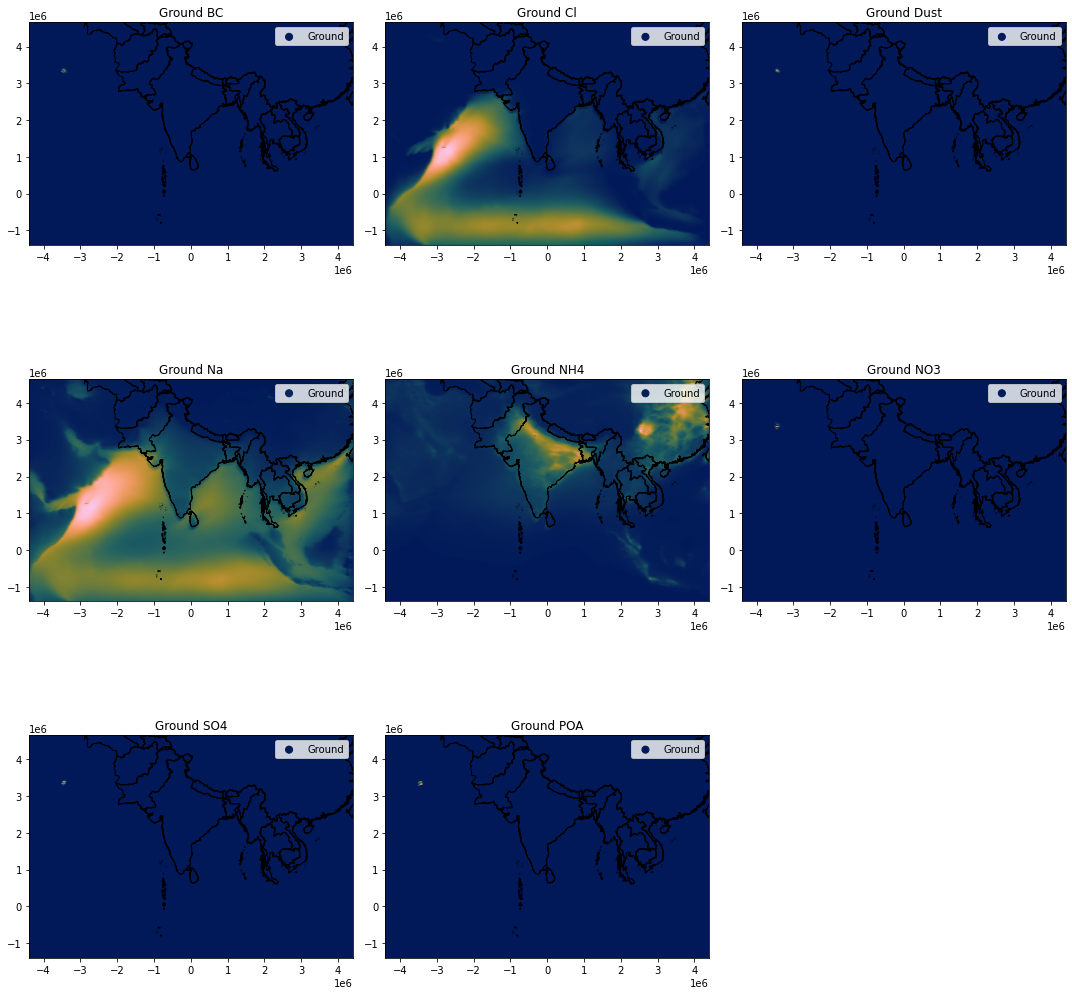

In [3]:
#Plot needs to be modified
borders_path = '../INDIA_WORLD_POP/data/asia/asia.shp'
input_path = 'Processed_Emissions_2019_Pavitra/Validation_Data/2017_WRF_baseline_combined_ug_m3_mercator.shp'
pollutants = ['BC', 'Cl', 'Dust', 'Na', 'NH4', 'NO3', 'SO4', 'POA']
target_crs = "+proj=merc +units=m +a=6370000.0 +b=6370000. +lon_0=80.0 +lat_ts=15.0"

gdf = gpd.read_file(input_path)
gdf = gdf.to_crs(target_crs)

border_gdf = gpd.read_file(borders_path)
border_gdf = border_gdf.to_crs(target_crs)

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.subplots_adjust(hspace=0.5)

for i, pollutant in enumerate(pollutants):
    # Calculate the subplot index (row and column)
    row = i // 3
    col = i % 3

    # Plot the pollutant points on the current subplot
    ground_layer = gdf
    ax = axes[row, col]
    ground_layer.plot(ax=ax, marker='o', markersize=50, label='Ground', column=pollutant, cmap=cm.batlow)
    ax.set_title(f"Ground {pollutant}")
    
    # Plot the country borders on the current subplot
    border_gdf.plot(ax=ax, edgecolor='black', color='none')

    # Set x and y limits based on point values for the current subplot
    x_min, y_min, x_max, y_max = gdf.geometry.total_bounds
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.legend(loc="upper right")

# Remove any empty subplots
for i in range(len(pollutants), 9):
    row = i // 3
    col = i % 3
    fig.delaxes(axes[row, col])

# Show the plot
plt.tight_layout()
plt.show()

In [64]:
gdf=gpd.read_file('Processed_Emissions_2019_Pavitra/Validation_Data/2017_WRF_baseline_combined_ug_m3_mercator.shp')
gdf.head()

,BC,Cl,Dust,Na,NH4,NO3,SO4,POA,geometry
0,0.206555,0.001524,0.232542,0.029620,0.100014,0.052835,0.355817,1.925294,POINT (-4400999.973 -1394439.483)
1,0.199994,0.001581,0.233815,0.030016,0.099652,0.054128,0.355835,1.813164,POINT (-4373999.872 -1394439.483)
2,0.200302,0.003747,0.251870,0.036022,0.096737,0.060222,0.352096,1.749321,POINT (-4347000.182 -1394439.483)
3,0.201746,0.005559,0.285908,0.041413,0.090221,0.053508,0.352054,1.654282,POINT (-4320000.081 -1394439.483)
4,0.207241,0.008492,0.325116,0.049884,0.081485,0.052440,0.350473,1.575376,POINT (-4292999.981 -1394439.483)
